In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [2]:
import jax
import jax.numpy as jnp
from functools import partial
import gwjax
import gwjax.imrphenom

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
ifos = ['H1', 'L1']

In [4]:
def condition(strain):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2,2)
    return (1e23*tmp)

def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

def whiten(strain):
    psd = estimate_psd(strain, strain.delta_f)
    return (strain.to_frequencyseries() / np.sqrt(psd)).to_timeseries()

In [5]:
merger = Merger("GW150914")
gps_time = merger.time

# Get the data and estimate the PSDs
strain = {ifo: condition(merger.strain(ifo)) for ifo in ifos}

wdata = {}
invasd = {}
for ifo in ifos:
    data = strain[ifo]
    
    srate = int(1/data.delta_t)
    idx = int(srate * (gps_time - data.start_time))
    
    wdata[ifo] = whiten(data)[idx-4*srate:idx+4*srate]
    invasd[ifo] = estimate_psd(data, 1/8)**-0.5

kmin, kmax = 15*8, 900*8

In [6]:
gmst = gwjax.gmst(gps_time)

In [7]:
freqs = jnp.arange(1+1024*8, dtype=jnp.float32)/8

In [8]:
params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': 36, 'm2': 29, 'spin1': 0., 'spin2': 0.,
            'ra': 0., 'dec': 0., 'pol': 0.}

In [9]:
def project_to_detector(params, htup, freqs, invasd, detector, gmst):
    deltat = gwjax.time_delay_from_earth_center(detector, gmst,
                                                params['ra'], params['dec'])
    fp, fx = gwjax.antenna_pattern(detector, gmst,
                                    params['ra'], params['dec'], params['pol'])
    return invasd*(fp*htup[0] + fx*htup[1])*jnp.exp(-1.j*2*jnp.pi*freqs*deltat)

def waveform_projections(params, freqs, project_dict, gmst):
    htup = gwjax.imrphenom.IMRPhenomD(freqs, params)
    return {ifo: project(params, htup) for ifo, project in project_dict.items()}

In [10]:
invasd['H1'].shape, freqs.shape

((8193,), (8193,))

In [11]:
fdata = {}
for ifo in ifos:
    fdata[ifo] = jnp.fft.rfft(jnp.array(np.roll(wdata[ifo], -4*srate), dtype=jnp.float32))

invasd = {ifo: jnp.array(iasd, dtype=jnp.float32) for ifo, iasd in invasd.items()}

project = {}
for ifo in ifos:
    project[ifo] = jax.jit(partial(project_to_detector,
                                        freqs=freqs[kmin:kmax],
                                        invasd=invasd[ifo][kmin:kmax],
                                        detector=gwjax.detectors[ifo],
                                        gmst=gmst))

waveform_projections = jax.jit(partial(waveform_projections,
                                        freqs=freqs[kmin:kmax],
                                        project_dict=project,
                                        gmst=gmst))

In [12]:
%timeit waveform_projections(params)

6.59 ms ± 77.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
def cbc_model(fdata=None):
    amp = numpyro.sample("amp", dist.Normal(0, 10))
    t = numpyro.sample("time", dist.Normal(0, 0.01))
    phase = numpyro.sample('phase', dist.Uniform(-jnp.pi, jnp.pi))
    m1 = numpyro.sample('m1', dist.Uniform(20, 50))
    m2 = numpyro.sample('m2', dist.Uniform(20, 50))
    ra = numpyro.sample('ra', dist.Uniform(-jnp.pi, jnp.pi))
    dec = numpyro.sample('dec', dist.Uniform(0., jnp.pi))
    pol = numpyro.sample('psi', dist.Uniform(0, 2*jnp.pi))

    proj_wfs = waveform_projections({'phase': phase, 'geocent_time': t,
            'luminosity_distance': amp, 'theta_jn': 0., 
            'm1': 36, 'm2': 29, 'spin1': 0., 'spin2': 0.,
            'ra': ra, 'dec': dec, 'pol': pol})

    numpyro.sample("y1", CplxNormal(proj_wfs['H1']), obs=fdata['H1'])
    numpyro.sample("y2", CplxNormal(proj_wfs['L1']), obs=fdata['L1'])

In [14]:
import numpyro
from numpyro import infer
from numpyro import distributions as dist

In [15]:
from gwjax import CplxNormal

In [16]:
# Define Bayesian sampler
sampler = infer.MCMC(
    infer.NUTS(cbc_model),
    num_warmup=100,
    num_samples=100,
    num_chains=1,
    progress_bar=True,
)

In [17]:
fdata_tst = waveform_projections(params)

In [18]:
%time sampler.run(jax.random.PRNGKey(0), fdata=fdata_tst)

sample: 100%|██████████| 200/200 [06:32<00:00,  1.96s/it, 1023 steps of size 1.49e-03. acc. prob=0.84]


CPU times: user 6min 37s, sys: 472 ms, total: 6min 37s
Wall time: 6min 37s


In [19]:
import arviz as az
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='stats')

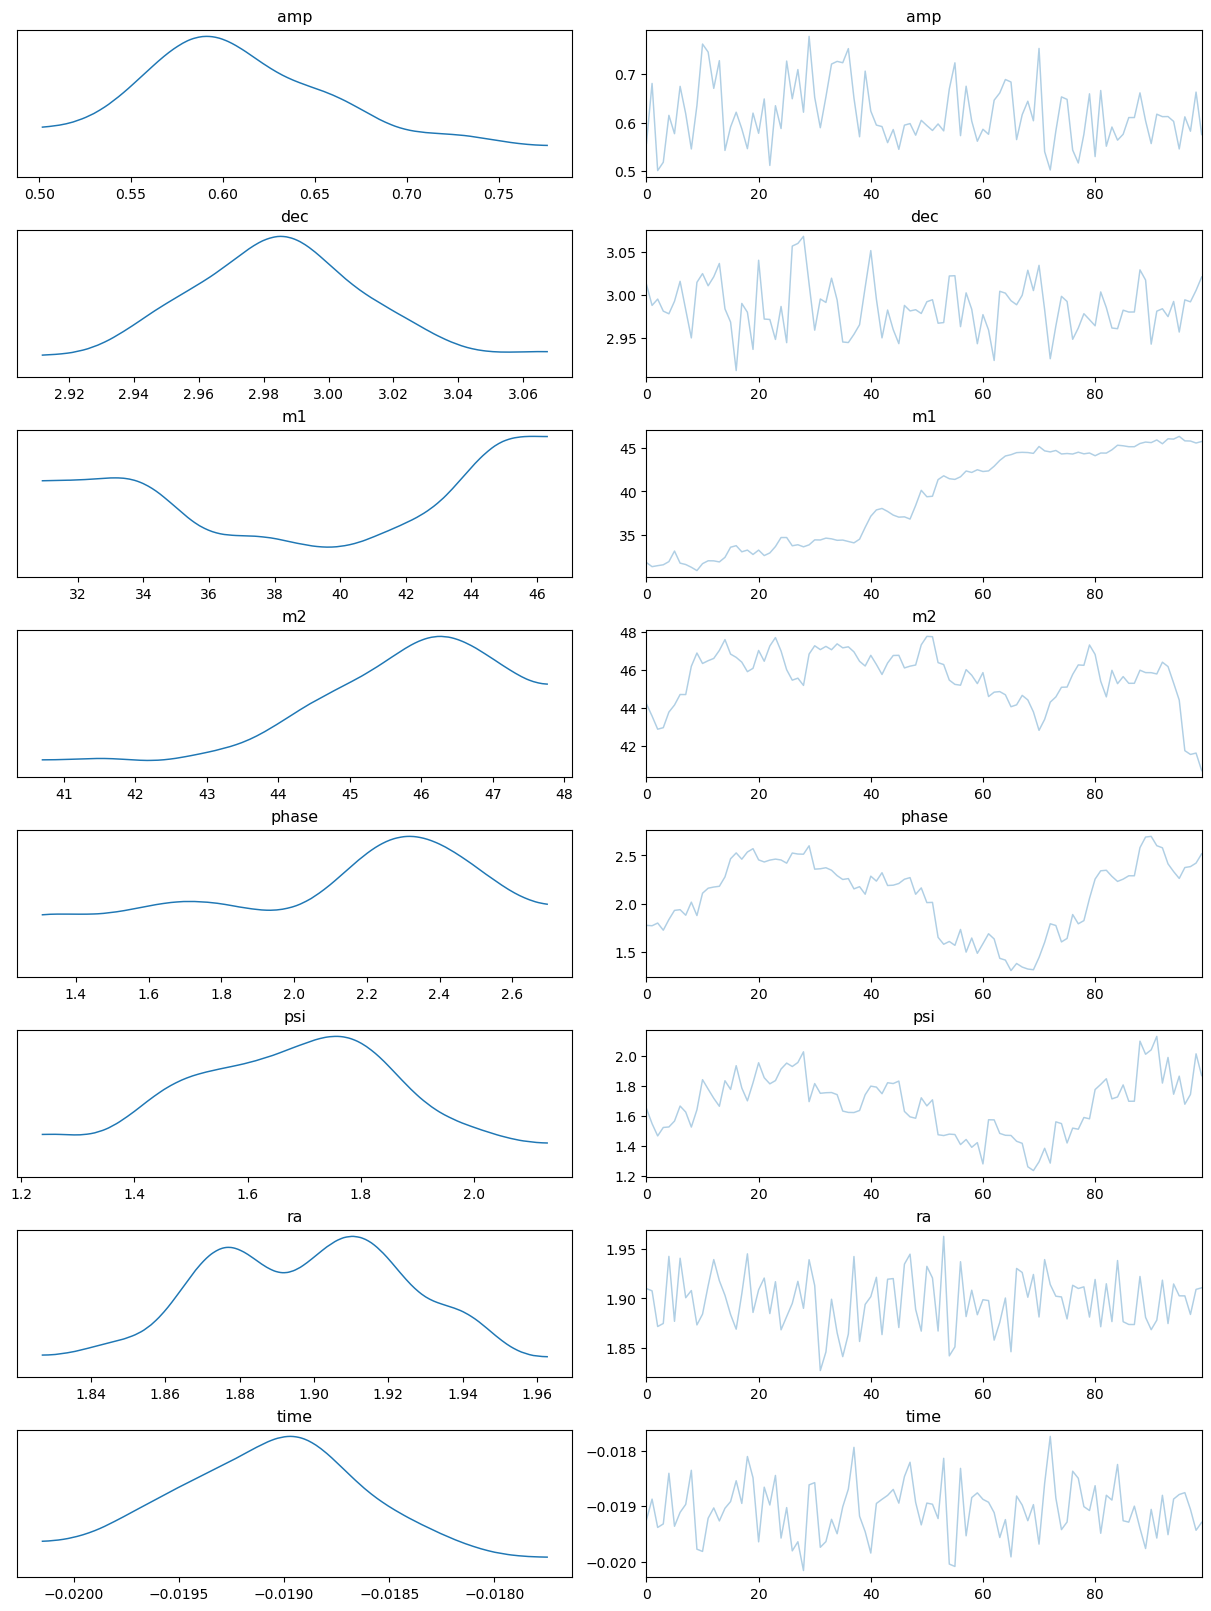

In [20]:
az.plot_trace(itrace);

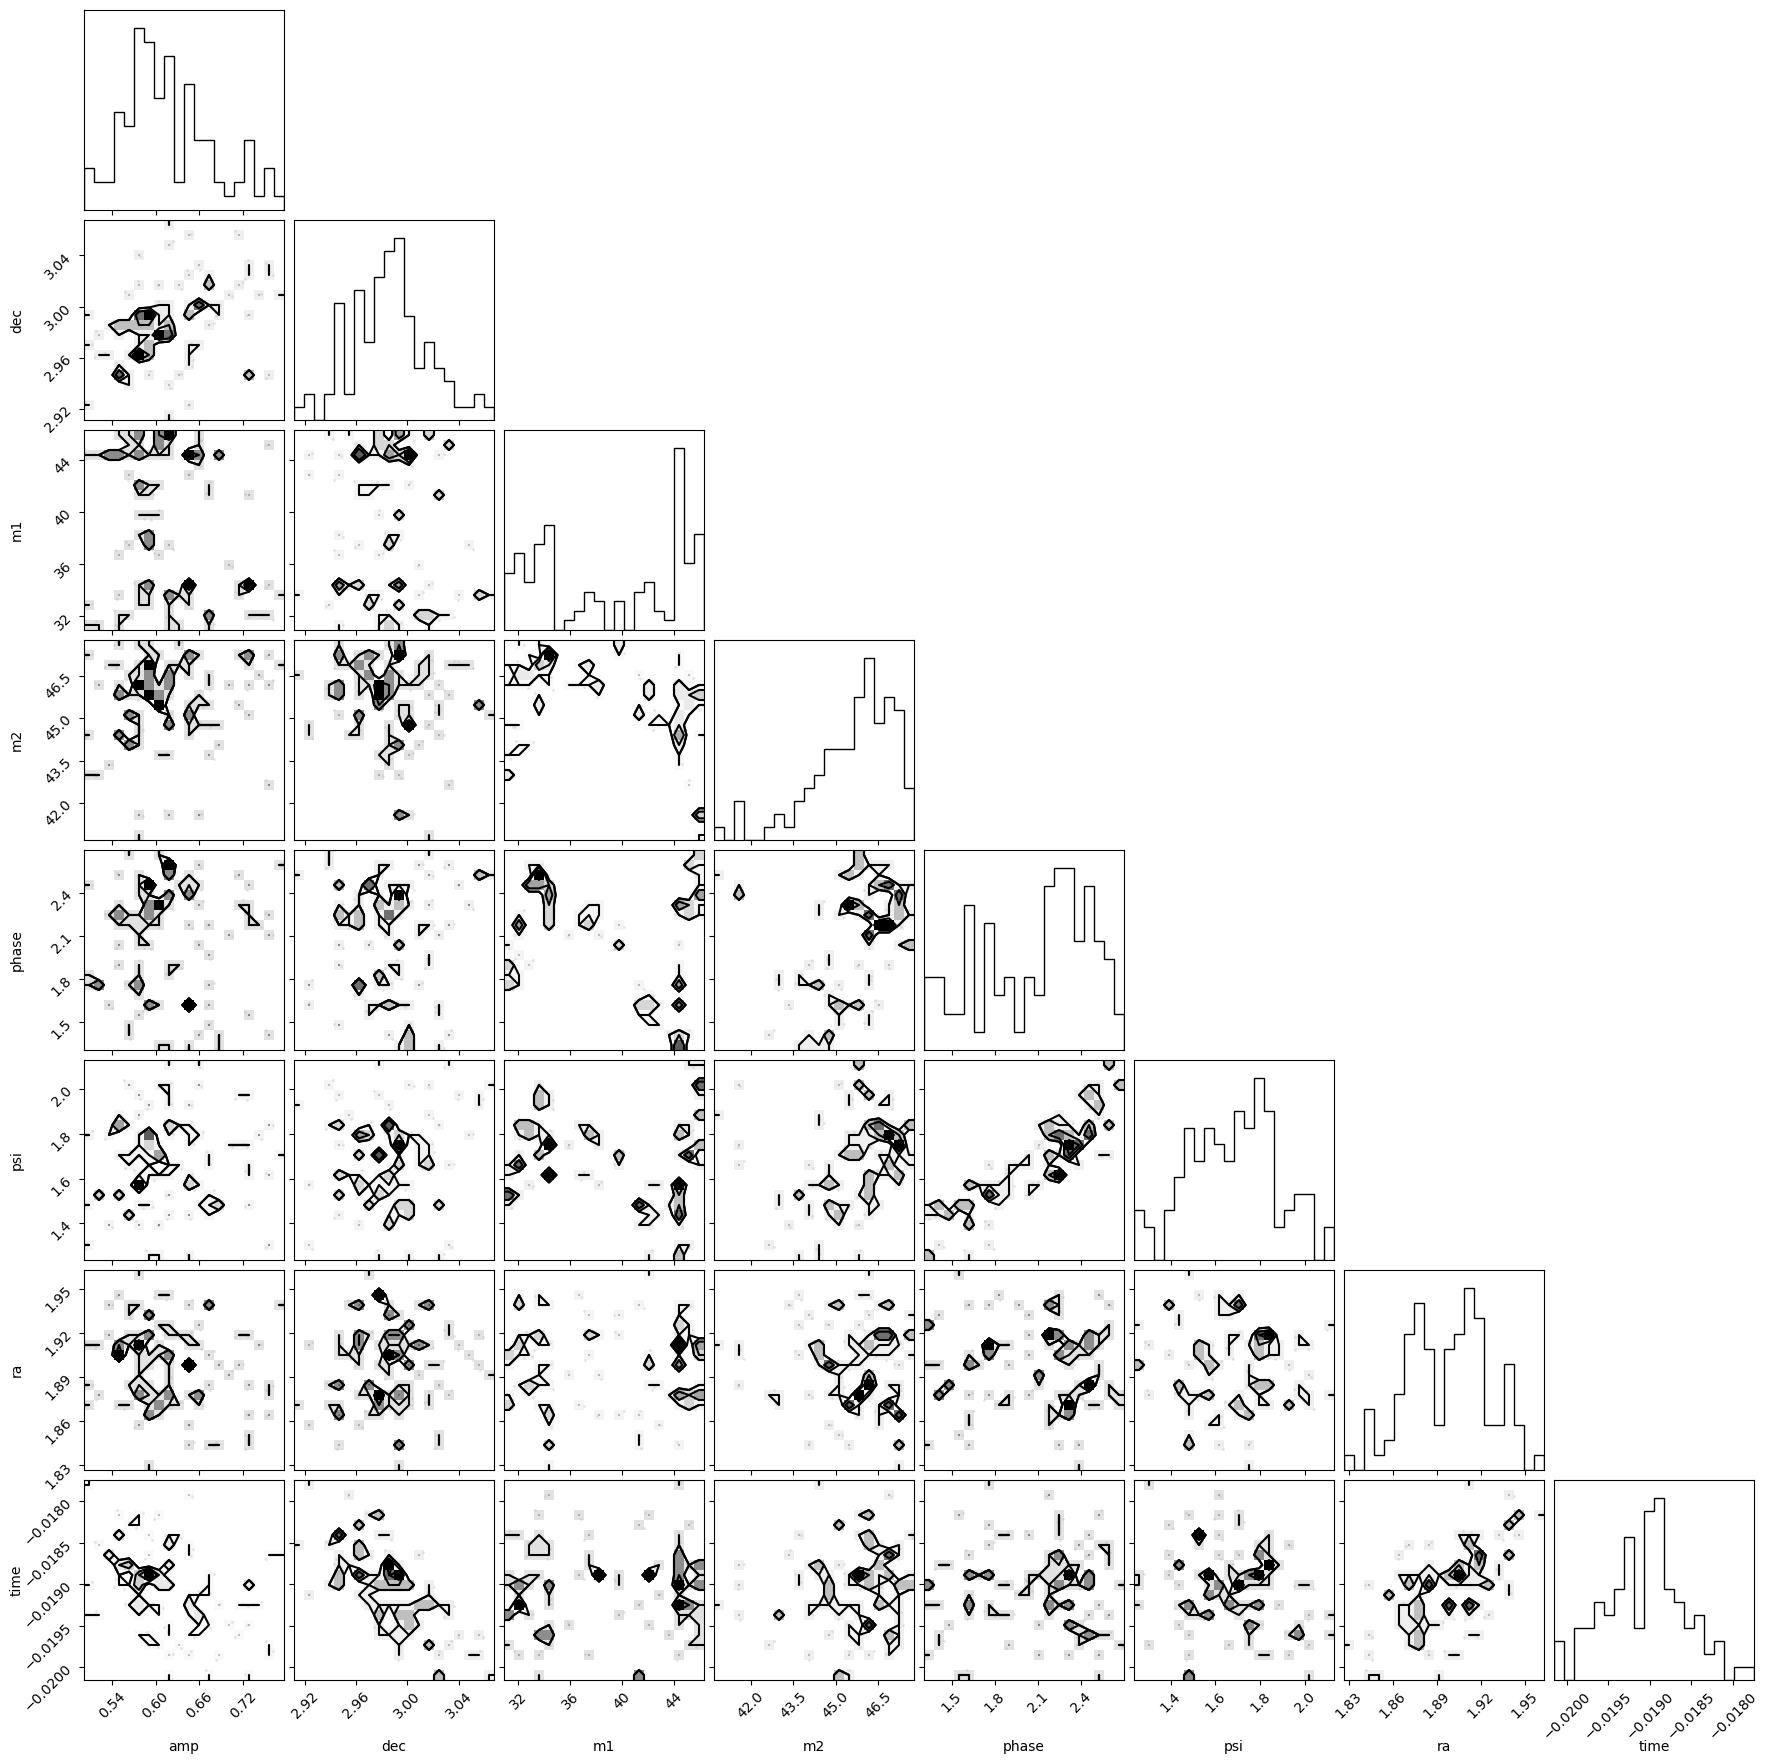

In [21]:
import corner

corner.corner(itrace);